
This script is used to obtain an optimised network architecture. It uses Optuna to minimize the objective function.


In [ ]:
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.0/616.0 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.7 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import optuna
from optuna.trial import TrialState
from sklearn.model_selection import train_test_split
from datetime import datetime
import math

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# Constants
n_trials = 500 # number of trials to perform
dimension = 2 # dimension of dataset
noise = False # add noise to the dataset
dataset_type = 'square' # 'circle' or 'square'
N = 3200 # number of points in the dataset
num_epochs = 100 # number of epochs before training is stopped
batch_size = 32
learning_rate = 0.001 # learning rate for training
slope = 0.01 # slope for Leaky functions
patience = 6

In [ ]:
# Utils

def sumOne(u):
  u = Positive(u)
  u = u/torch.sum(u)
  return Positive(u)

def Positive(X):
    return torch.abs(X)

# From https://github.com/JiJingYu/delta_orthogonal_init_pytorch/blob/master/demo.py
def genOrthgonal(dim):
    a = torch.zeros((dim, dim)).normal_(0, 1)
    q, r = torch.linalg.qr(a)
    d = torch.diag(r, 0).sign()
    diag_size = d.size(0)
    d_exp = d.view(1, diag_size).expand(diag_size, diag_size)
    q.mul_(d_exp)
    return q

def makeDeltaOrthogonal(weights, gain):
    rows = weights.size(0)
    cols = weights.size(1)
    if rows > cols:
        print("In_filters should not be greater than out_filters.")
    weights.data.fill_(0)
    dim = max(rows, cols)
    q = genOrthgonal(dim)
    # mid1 = weights.size(2) // 2
    # mid2 = weights.size(3) // 2
    # weights[:, :, mid1, mid2] = q[:weights.size(0), :weights.size(1)]
    weigths = q
    weights.mul_(gain)

#Convolutional layers
def deconv_orth_dist(kernel, padding = 2, stride = 1):
    [o_c, i_c, w, h] = kernel.shape
    output = torch.conv2d(kernel, kernel, padding=padding)
    target = torch.zeros((o_c, o_c, output.shape[-2], output.shape[-1])).to(kernel.device)
    ct = int(np.floor(output.shape[-1]/2))
    target[:,:,ct,ct] = torch.eye(o_c).to(kernel.device)
    return torch.norm( output - target )

def deconv_orth_dist_2d(matrix):
    [w, h] = matrix.shape
    target = torch.eye(w)
    # print(f'Matrix: {matrix}')
    # print(f'Target: {target}')
    return torch.linalg.matrix_norm(matrix-target,2)


def conv_orth_dist(kernel, stride = 1):
    [o_c, i_c, w, h] = kernel.shape
    assert (w == h),"Do not support rectangular kernel"
    assert stride<w,"Please use matrix orthgonality instead"
    new_s = stride*(w-1) + w#np.int(2*(half+np.floor(half/stride))+1)
    temp = torch.eye(new_s*new_s*i_c).reshape((new_s*new_s*i_c, i_c, new_s,new_s)).to(kernel.device)
    out = (F.conv2d(temp, kernel, stride=stride)).reshape((new_s*new_s*i_c, -1))
    Vmat = out[np.floor(new_s**2/2).astype(int)::new_s**2, :]
    temp= np.zeros((i_c, i_c*new_s**2))
    for i in range(temp.shape[0]):temp[i,np.floor(new_s**2/2).astype(int)+new_s**2*i]=1
    return torch.norm( Vmat@torch.t(out) - torch.from_numpy(temp).float().to(kernel.device) )

#Fully connected layers
def orth_dist(mat, stride=None):
    mat = mat.reshape( (mat.shape[0], -1) )
    if mat.shape[0] < mat.shape[1]:
        mat = mat.permute(1,0)
    return torch.norm( torch.t(mat)@mat - torch.eye(mat.shape[1]).to(mat.device))

def power_method(A, A_t, u_init, k=1):
    u = u_init
    for i in range(k):
        v = A(u)
        v /= torch.sqrt(torch.sum(v**2))
        u = A_t(v)
        sigma = torch.sum(u * u)
        u /= torch.sqrt(torch.sum(u**2))
    return sigma, u[0] #so it returns a 3d tensor

def compute_spectral_norm(conv, u_init=None, im_size=(3, 32, 32), k=1):
    if u_init is None:
        with torch.no_grad():
            u_init = torch.randn(1, *im_size).to(conv.weight.device)
    u_init = u_init.to(conv.weight.device)
    with torch.no_grad():
        return power_method(lambda u: torch.nn.functional.conv2d(u, conv.weight, padding=tuple(v//2 for v in conv.weight.shape[2:])),
                lambda v: torch.nn.functional.conv_transpose2d(v, conv.weight, padding=tuple(v//2 for v in conv.weight.shape[2:])),
                u_init, k)

def conv_block(in_channels, out_channels, pool=False):
    convo = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1,bias=False)
    layers = [convo]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)



In [ ]:
class multiClassHingeLoss(nn.Module): # From paper Dynamical Systems
    def __init__(self, p=1, margin=0.1, device='cpu', size_average=True):
        super(multiClassHingeLoss, self).__init__()
        self.margin=margin
        self.size_average=size_average
        self.device = device

    def forward(self, output, y):
        output_y=output[torch.arange(0,y.size()[0]).long().to(self.device),y.data.to(self.device)].view(-1,1) #it is a (Batch Size x 1) tensor, having entries that are x[y]
        loss=output-output_y+self.margin #this has self.margin in position y and the difference between the entry of x and x[y] in the other positions
        #remove i=y items
        loss[torch.arange(0,y.size()[0]).long().to(self.device),y.data.to(self.device)]=0 #sets to 0 the entry in position y, instead of having self.margin
        #max(0,_)
        loss[loss<0]=0 #sets to 0 the entries of loss where we have negative numbers, i.e. those meeting the margin (there is a higher difference than the margin between x[y] and x[i])
        #sum up
        loss=torch.sum(loss)
        if(self.size_average):
            loss/=output.size()[0]
        return loss

In [ ]:
# Functions used to generate datasets
num_points = N
def GenerateCircleDataset(noise=False):
  # Generate random points
  points = np.random.randn(num_points, dimension)

  # Calculate distances to the origin
  distances = np.linalg.norm(points, axis=1)

  # Generate labels: 0 if distance < 2/3, 1 if 2/3 < distance < 4/3, 2 if distance > 4/3
  labels = np.zeros_like(distances)
  labels[distances > 2/3] = 1
  labels[distances > 4/3] = 2

  # Convert numpy arrays to PyTorch tensors
  labels_tensor = torch.tensor(labels, dtype=torch.long)
  if noise:
    noise = 0.1*np.random.randn(num_points, dimension)
    noisy_points = points + noise
    points_tensor = torch.tensor(noisy_points, dtype=torch.float32)
  else:
    points_tensor = torch.tensor(points, dtype=torch.float32)

  return points_tensor, labels_tensor

def GenerateSquareDataset(noise=False):
    # Generate random points uniformly between -1 and 1
    points = np.random.uniform(low=-1.0, high=1.0, size=(num_points, dimension))

    # Initialize labels
    labels = np.zeros(num_points)

    # Assign labels based on quadrant
    for i, point in enumerate(points):
        if point[0] >= 0 and point[1] >= 0:
            labels[i] = 0  # Quadrant 1
        elif point[0] < 0 and point[1] >= 0:
            labels[i] = 1  # Quadrant 2
        elif point[0] < 0 and point[1] < 0:
            labels[i] = 2  # Quadrant 3
        else:
            labels[i] = 3  # Quadrant 4

    # Convert numpy arrays to PyTorch tensors
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    if noise:
        # Add noise to the points
        noise = 0.1 * np.random.randn(num_points, dimension)
        noisy_points = points + noise
        points_tensor = torch.tensor(noisy_points, dtype=torch.float32)
    else:
        points_tensor = torch.tensor(points, dtype=torch.float32)

    return points_tensor, labels_tensor

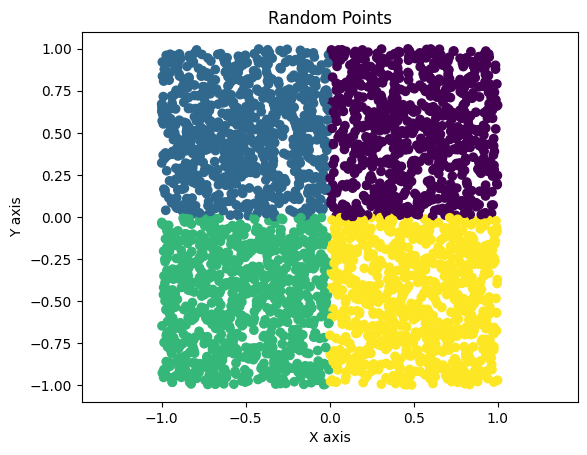

In [ ]:
# Generate training data

if dataset_type == 'circle':
  points_tensor, labels_tensor = GenerateCircleDataset(noise=noise)
elif dataset_type == 'square':
  points_tensor, labels_tensor = GenerateSquareDataset(noise=noise)

# Create a scatter plot
plt.axis('equal')
plt.scatter(points_tensor[:,0], points_tensor[:,1], c=labels_tensor)

# Set the title and labels
plt.title('Random Points')
plt.xlabel('X axis')
plt.ylabel('Y axis')


# Generate validation data
if dataset_type == 'circle':
  val_points_tensor, val_labels_tensor = GenerateCircleDataset(noise=False) # no noise on validation data
elif dataset_type == 'square':
  test_points_tensor, test_labels_tensor = GenerateSquareDataset(noise=False)


In [ ]:
if dataset_type == 'circle':
    num_outputs = 3
elif dataset_type == 'square':
    num_outputs = 4
else:
    raise ValueError("Invalid dataset type")

class DynamicModel(nn.Module): # Fully connected model
    def __init__(self, trial):
        super(DynamicModel, self).__init__()
        self.layers = nn.ModuleList()
        n_layers = trial.suggest_int('n_layers', 2, 5)  # Suggesting between 2 and 5 layers

        in_features = dimension
        for i in range(n_layers):
            out_features = trial.suggest_int(f'n_units_l{i}', 2, 128)
            self.layers.append(nn.Linear(in_features, out_features))
            in_features = out_features

        self.layers.append(nn.Linear(out_features, num_outputs))  # Output layer

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x

def objective(trial):
    # Create a dynamic model based on the trial's suggestions
    model = DynamicModel(trial).to(device)

    # Loss function and optimizer
    # criterion = nn.CrossEntropyLoss()
    criterion = multiClassHingeLoss(margin=margin)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for i in range(0, N, batch_size):
          inputs = points_tensor[i:i+batch_size]
          targets = labels_tensor[i:i+batch_size]
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, N, batch_size):
            batch_features = val_points_tensor[i:i+batch_size]
            batch_labels = val_labels_tensor[i:i+batch_size]

            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()
    val_loss /= (N // batch_size)  # Average validation loss over batches

    return val_loss

class ExpansiveContractiveNet(nn.Module):
    def __init__(self, trial, nl, in_channels=dimension, sub_steps=1):
        super(ExpansiveContractiveNet, self).__init__()
        n_blocks = trial.suggest_int('n_blocks', 1, 20)
        self.nlayers = n_blocks*2 # how many total layers? = blocks * 2
        self.nl = nl  # activation function
        self.slope = 0.01
        self.sub_steps = sub_steps
        self.u = torch.nn.Parameter(torch.rand(self.nlayers))
        self.rescalings = nn.Parameter(torch.rand(1+self.nlayers//2))

        # Layers
        self.nodes_per_layer = trial.suggest_int('nodes_per_layer', 2, 64)

        self.lift = nn.Linear(in_channels, self.nodes_per_layer)

        self.inner_layers = nn.ModuleList([nn.Linear(self.nodes_per_layer, self.nodes_per_layer) for i in range(self.nlayers)])

        self.project = nn.Linear(self.nodes_per_layer, 4)

        self.rescalings = nn.Parameter(torch.rand(1+self.nlayers//2))

    def getDepth(self):
        return self.nlayers

    def getReg(self,):
        reg = 0
        for i in range(self.nlayers):
            reg += deconv_orth_dist_2d(self.inner_layers[i].weight)
        return reg

    def forward(self, x):
        self.rescalings.data[:-1] = torch.clip(self.rescalings.data[:-1],min=0,max=1)
        x = torch.relu(self.rescalings[-1] * self.lift(x))

        dts = Positive(self.u)

        for i in np.arange(0,self.nlayers,2):

          dte = dts[i]/self.sub_steps
          dtc = dts[i+1]/self.sub_steps
          Ae = self.inner_layers[i]
          Ac = self.inner_layers[i+1]

          for k in range(self.sub_steps):
                x = x + dte * self.rescalings[i//2] * self.nl(Ae(x), self.slope)
                x = x - dtc * self.nl(Ac(x), self.slope)

        x = self.project(x) # project to number of labels
        return x

def objective_lipschitz_constrained(trial):
    # Create a dynamic model based on the trial's suggestions
    # model = DynamicModel(trial).to(device)
    model = ExpansiveContractiveNet(trial, nl=F.relu).to(device)

    # Loss function and optimizer
    margin = 0.0013
    # criterion = nn.CrossEntropyLoss()
    criterion = multiClassHingeLoss(margin=margin)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)


    train_points, val_points, train_labels, val_labels = train_test_split(points_tensor, labels_tensor, test_size=0.2)

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    gamma = .1 # used to scale the orthogonal constraint regulaiton

    for epoch in range(1000):
        model.train()
        for i in range(0, len(train_points), batch_size):
          inputs = train_points[i:i+batch_size]
          targets = train_labels[i:i+batch_size]

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets)

          if True:
                loss += gamma * model.getReg()
          if math.isnan(loss.item()) or math.isinf(loss.item()):
              print("NaN loss detected, stopping training.")
              return -1
          loss.backward()
          optimizer.step()
          if True:
                with torch.no_grad():
                    refLip = 1

                    lift_norm = torch.linalg.matrix_norm(model.lift.weight.data,2)
                    model.lift.weight.data /= max(1,lift_norm/refLip)

                for q in range(model.getDepth()):
                  norm = torch.linalg.matrix_norm(model.inner_layers[q].weight.data,2)
                  model.inner_layers[q].weight.data /= max(1,norm/refLip)

        # Compute accuracy on test set
        model.eval()
        with torch.no_grad():
            norms = []
            nonort = []
            lift = []
            liftOrt = []

            n = torch.linalg.matrix_norm(model.lift.weight.data,2)
            lift.append(n.item())
            for s in range(model.getDepth()):
              n = torch.linalg.matrix_norm(model.inner_layers[s].weight.data,2)
              nonort.append(deconv_orth_dist_2d(model.inner_layers[s].weight).item())
            outputs = model(test_points_tensor)
            _, predicted = torch.max(outputs, 1) # Maximum along axis=1
            accuracy = (predicted == test_labels_tensor).float().mean()

            outputs = model(test_points_tensor)
            loss = criterion(outputs, test_labels_tensor)
            test_loss = loss.item()

        # Validation step
        val_loss = 0.0
        with torch.no_grad():
            for i in range(0, len(val_points), batch_size):
                inputs = val_points[i:i+batch_size]
                targets = val_labels[i:i+batch_size]
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                if torch.isnan(loss) or math.isinf(loss.item()):
                  print("NaN loss detected, stopping training.")
                  return -1, -1, epoch
                val_loss += loss.item()

        val_loss /= len(val_points) // batch_size
        # print(f'Time: {datetime.now().strftime("%H:%M:%S")}, Epoch [{epoch+1}/{1000}], Loss: {loss.item()}, Val Loss: {val_loss}, Epochs without improvement:{epochs_without_improvement}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    return accuracy


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_lipschitz_constrained, n_trials=n_trials)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-08-02 15:42:47,219] A new study created in memory with name: no-name-b4ab1bfa-df7e-43c2-a456-e24cf4f40e4a
[I 2024-08-02 15:44:03,508] Trial 0 finished with value: 0.9106249809265137 and parameters: {'n_blocks': 13, 'nodes_per_layer': 51}. Best is trial 0 with value: 0.9106249809265137.


Early stopping triggered after 17 epochs


[I 2024-08-02 15:44:36,148] Trial 1 finished with value: 0.9606249928474426 and parameters: {'n_blocks': 12, 'nodes_per_layer': 39}. Best is trial 0 with value: 0.9106249809265137.


Early stopping triggered after 11 epochs


[I 2024-08-02 15:44:48,917] Trial 2 finished with value: 0.9424999952316284 and parameters: {'n_blocks': 6, 'nodes_per_layer': 22}. Best is trial 0 with value: 0.9106249809265137.


Early stopping triggered after 16 epochs


[I 2024-08-02 15:45:41,895] Trial 3 finished with value: 0.9181249737739563 and parameters: {'n_blocks': 17, 'nodes_per_layer': 56}. Best is trial 0 with value: 0.9106249809265137.


Early stopping triggered after 9 epochs


[I 2024-08-02 15:46:17,999] Trial 4 finished with value: 0.8190624713897705 and parameters: {'n_blocks': 11, 'nodes_per_layer': 40}. Best is trial 4 with value: 0.8190624713897705.


Early stopping triggered after 13 epochs


[I 2024-08-02 15:46:58,897] Trial 5 finished with value: 0.9396874904632568 and parameters: {'n_blocks': 14, 'nodes_per_layer': 47}. Best is trial 4 with value: 0.8190624713897705.


Early stopping triggered after 10 epochs


[I 2024-08-02 15:47:18,430] Trial 6 finished with value: 0.8862500190734863 and parameters: {'n_blocks': 6, 'nodes_per_layer': 62}. Best is trial 4 with value: 0.8190624713897705.


Early stopping triggered after 8 epochs


[I 2024-08-02 15:47:31,224] Trial 7 finished with value: 0.8990625143051147 and parameters: {'n_blocks': 6, 'nodes_per_layer': 5}. Best is trial 4 with value: 0.8190624713897705.


Early stopping triggered after 21 epochs


[I 2024-08-02 15:47:38,931] Trial 8 finished with value: 0.8403124809265137 and parameters: {'n_blocks': 7, 'nodes_per_layer': 9}. Best is trial 4 with value: 0.8190624713897705.


Early stopping triggered after 11 epochs


[I 2024-08-02 15:47:47,198] Trial 9 finished with value: 0.9043750166893005 and parameters: {'n_blocks': 7, 'nodes_per_layer': 31}. Best is trial 4 with value: 0.8190624713897705.


Early stopping triggered after 8 epochs


[I 2024-08-02 15:47:57,505] Trial 10 finished with value: 0.9509375095367432 and parameters: {'n_blocks': 2, 'nodes_per_layer': 27}. Best is trial 4 with value: 0.8190624713897705.


Early stopping triggered after 27 epochs


[I 2024-08-02 15:48:18,701] Trial 11 finished with value: 0.5628125071525574 and parameters: {'n_blocks': 9, 'nodes_per_layer': 3}. Best is trial 11 with value: 0.5628125071525574.


Early stopping triggered after 26 epochs


[I 2024-08-02 15:48:28,113] Trial 12 finished with value: 0.9412500262260437 and parameters: {'n_blocks': 10, 'nodes_per_layer': 17}. Best is trial 11 with value: 0.5628125071525574.


Early stopping triggered after 9 epochs


[I 2024-08-02 15:48:56,499] Trial 13 finished with value: 0.9775000214576721 and parameters: {'n_blocks': 10, 'nodes_per_layer': 40}. Best is trial 11 with value: 0.5628125071525574.


Early stopping triggered after 11 epochs


[I 2024-08-02 15:49:15,173] Trial 14 finished with value: 0.6612499952316284 and parameters: {'n_blocks': 20, 'nodes_per_layer': 15}. Best is trial 11 with value: 0.5628125071525574.


Early stopping triggered after 10 epochs


[I 2024-08-02 15:49:49,739] Trial 15 finished with value: 0.25062501430511475 and parameters: {'n_blocks': 20, 'nodes_per_layer': 1}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 23 epochs


[I 2024-08-02 15:50:20,484] Trial 16 finished with value: 0.47343748807907104 and parameters: {'n_blocks': 16, 'nodes_per_layer': 2}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 22 epochs


[I 2024-08-02 15:50:44,140] Trial 17 finished with value: 0.5874999761581421 and parameters: {'n_blocks': 20, 'nodes_per_layer': 1}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 15 epochs


[I 2024-08-02 15:51:16,104] Trial 18 finished with value: 0.9275000095367432 and parameters: {'n_blocks': 16, 'nodes_per_layer': 11}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 20 epochs


[I 2024-08-02 15:51:44,226] Trial 19 finished with value: 0.9446874856948853 and parameters: {'n_blocks': 17, 'nodes_per_layer': 21}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 15 epochs


[I 2024-08-02 15:52:10,841] Trial 20 finished with value: 0.917187511920929 and parameters: {'n_blocks': 18, 'nodes_per_layer': 8}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 17 epochs


[I 2024-08-02 15:52:32,145] Trial 21 finished with value: 0.5028125047683716 and parameters: {'n_blocks': 15, 'nodes_per_layer': 3}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 17 epochs


[I 2024-08-02 15:52:58,174] Trial 22 finished with value: 0.25062501430511475 and parameters: {'n_blocks': 14, 'nodes_per_layer': 1}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 24 epochs


[I 2024-08-02 15:53:12,019] Trial 23 finished with value: 0.9490625262260437 and parameters: {'n_blocks': 19, 'nodes_per_layer': 13}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 8 epochs


[I 2024-08-02 15:53:27,225] Trial 24 finished with value: 0.2540625035762787 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 13 epochs


[I 2024-08-02 15:53:43,335] Trial 25 finished with value: 0.8103125095367432 and parameters: {'n_blocks': 13, 'nodes_per_layer': 7}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 14 epochs


[I 2024-08-02 15:54:01,431] Trial 26 finished with value: 0.9431250095367432 and parameters: {'n_blocks': 15, 'nodes_per_layer': 17}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 12 epochs


[I 2024-08-02 15:54:21,243] Trial 27 finished with value: 0.6781250238418579 and parameters: {'n_blocks': 18, 'nodes_per_layer': 23}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 10 epochs


[I 2024-08-02 15:54:56,690] Trial 28 finished with value: 0.9353125095367432 and parameters: {'n_blocks': 15, 'nodes_per_layer': 12}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 25 epochs


[I 2024-08-02 15:55:08,453] Trial 29 finished with value: 0.7912499904632568 and parameters: {'n_blocks': 13, 'nodes_per_layer': 7}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 10 epochs


[I 2024-08-02 15:55:38,273] Trial 30 finished with value: 0.3890624940395355 and parameters: {'n_blocks': 19, 'nodes_per_layer': 1}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 21 epochs


[I 2024-08-02 15:55:58,200] Trial 31 finished with value: 0.5790625214576721 and parameters: {'n_blocks': 19, 'nodes_per_layer': 1}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 14 epochs


[I 2024-08-02 15:56:21,275] Trial 32 finished with value: 0.8928124904632568 and parameters: {'n_blocks': 18, 'nodes_per_layer': 7}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 15 epochs


[I 2024-08-02 15:57:11,780] Trial 33 finished with value: 0.48875001072883606 and parameters: {'n_blocks': 20, 'nodes_per_layer': 1}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 34 epochs


[I 2024-08-02 15:57:34,550] Trial 34 finished with value: 0.8968750238418579 and parameters: {'n_blocks': 12, 'nodes_per_layer': 11}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 20 epochs


[I 2024-08-02 15:57:55,886] Trial 35 finished with value: 0.7190625071525574 and parameters: {'n_blocks': 17, 'nodes_per_layer': 5}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 15 epochs


[I 2024-08-02 15:58:18,365] Trial 36 finished with value: 0.9334375262260437 and parameters: {'n_blocks': 14, 'nodes_per_layer': 19}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 15 epochs


[I 2024-08-02 15:59:02,485] Trial 37 finished with value: 0.8924999833106995 and parameters: {'n_blocks': 19, 'nodes_per_layer': 48}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 8 epochs


[I 2024-08-02 15:59:24,987] Trial 38 finished with value: 0.9446874856948853 and parameters: {'n_blocks': 12, 'nodes_per_layer': 35}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 8 epochs


[I 2024-08-02 15:59:36,590] Trial 39 finished with value: 0.9303125143051147 and parameters: {'n_blocks': 16, 'nodes_per_layer': 10}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 8 epochs


[I 2024-08-02 16:00:22,541] Trial 40 finished with value: 0.9275000095367432 and parameters: {'n_blocks': 14, 'nodes_per_layer': 64}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 8 epochs


[I 2024-08-02 16:00:47,042] Trial 41 finished with value: 0.581250011920929 and parameters: {'n_blocks': 16, 'nodes_per_layer': 4}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 18 epochs


[I 2024-08-02 16:01:11,803] Trial 42 finished with value: 0.8543750047683716 and parameters: {'n_blocks': 18, 'nodes_per_layer': 5}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 16 epochs


[I 2024-08-02 16:01:34,463] Trial 43 finished with value: 0.4571875035762787 and parameters: {'n_blocks': 17, 'nodes_per_layer': 2}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 16 epochs


[I 2024-08-02 16:02:28,743] Trial 44 finished with value: 0.9721875190734863 and parameters: {'n_blocks': 17, 'nodes_per_layer': 57}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 9 epochs


[I 2024-08-02 16:02:53,719] Trial 45 finished with value: 0.6293749809265137 and parameters: {'n_blocks': 19, 'nodes_per_layer': 5}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 16 epochs


[I 2024-08-02 16:03:16,251] Trial 46 finished with value: 0.8346874713897705 and parameters: {'n_blocks': 17, 'nodes_per_layer': 14}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 14 epochs


[I 2024-08-02 16:03:55,999] Trial 47 finished with value: 0.9084374904632568 and parameters: {'n_blocks': 20, 'nodes_per_layer': 9}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 23 epochs


[I 2024-08-02 16:04:09,864] Trial 48 finished with value: 0.8506249785423279 and parameters: {'n_blocks': 15, 'nodes_per_layer': 25}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 8 epochs


[I 2024-08-02 16:04:37,527] Trial 49 finished with value: 0.5924999713897705 and parameters: {'n_blocks': 14, 'nodes_per_layer': 1}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 25 epochs


[I 2024-08-02 16:04:59,698] Trial 50 finished with value: 0.5790625214576721 and parameters: {'n_blocks': 11, 'nodes_per_layer': 4}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 21 epochs


[I 2024-08-02 16:06:53,430] Trial 51 finished with value: 0.9721875190734863 and parameters: {'n_blocks': 16, 'nodes_per_layer': 3}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 81 epochs


[I 2024-08-02 16:07:20,346] Trial 52 finished with value: 0.8978124856948853 and parameters: {'n_blocks': 13, 'nodes_per_layer': 8}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 22 epochs


[I 2024-08-02 16:07:37,481] Trial 53 finished with value: 0.41218748688697815 and parameters: {'n_blocks': 18, 'nodes_per_layer': 1}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 12 epochs


[I 2024-08-02 16:07:46,486] Trial 54 finished with value: 0.9624999761581421 and parameters: {'n_blocks': 3, 'nodes_per_layer': 6}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 22 epochs


[I 2024-08-02 16:08:10,559] Trial 55 finished with value: 0.6378124952316284 and parameters: {'n_blocks': 19, 'nodes_per_layer': 1}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 16 epochs


[I 2024-08-02 16:08:32,765] Trial 56 finished with value: 0.9750000238418579 and parameters: {'n_blocks': 18, 'nodes_per_layer': 16}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 12 epochs


[I 2024-08-02 16:09:18,749] Trial 57 finished with value: 0.9337499737739563 and parameters: {'n_blocks': 20, 'nodes_per_layer': 30}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 17 epochs


[I 2024-08-02 16:10:04,706] Trial 58 finished with value: 0.36531248688697815 and parameters: {'n_blocks': 17, 'nodes_per_layer': 3}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 31 epochs


[I 2024-08-02 16:10:35,721] Trial 59 finished with value: 0.9524999856948853 and parameters: {'n_blocks': 18, 'nodes_per_layer': 10}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 18 epochs


[I 2024-08-02 16:12:34,238] Trial 60 finished with value: 0.9793750047683716 and parameters: {'n_blocks': 19, 'nodes_per_layer': 44}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 25 epochs


[I 2024-08-02 16:13:08,331] Trial 61 finished with value: 0.5015624761581421 and parameters: {'n_blocks': 17, 'nodes_per_layer': 3}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 23 epochs


[I 2024-08-02 16:13:20,800] Trial 62 finished with value: 0.9137499928474426 and parameters: {'n_blocks': 17, 'nodes_per_layer': 6}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 8 epochs


[I 2024-08-02 16:13:38,205] Trial 63 finished with value: 0.3921875059604645 and parameters: {'n_blocks': 15, 'nodes_per_layer': 3}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 13 epochs


[I 2024-08-02 16:14:12,284] Trial 64 finished with value: 0.6621875166893005 and parameters: {'n_blocks': 15, 'nodes_per_layer': 8}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 24 epochs


[I 2024-08-02 16:14:42,851] Trial 65 finished with value: 0.45781248807907104 and parameters: {'n_blocks': 16, 'nodes_per_layer': 3}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 22 epochs


[I 2024-08-02 16:15:00,799] Trial 66 finished with value: 0.8940625190734863 and parameters: {'n_blocks': 18, 'nodes_per_layer': 13}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 10 epochs


[I 2024-08-02 16:15:16,496] Trial 67 finished with value: 0.8918750286102295 and parameters: {'n_blocks': 8, 'nodes_per_layer': 5}. Best is trial 15 with value: 0.25062501430511475.


Early stopping triggered after 20 epochs


[I 2024-08-02 16:15:45,670] Trial 68 finished with value: 0.23406249284744263 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 24 epochs


[I 2024-08-02 16:16:06,475] Trial 69 finished with value: 0.8565624952316284 and parameters: {'n_blocks': 14, 'nodes_per_layer': 7}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 16 epochs


[I 2024-08-02 16:16:16,524] Trial 70 finished with value: 0.9671875238418579 and parameters: {'n_blocks': 11, 'nodes_per_layer': 11}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 9 epochs


[I 2024-08-02 16:16:38,583] Trial 71 finished with value: 0.25062501430511475 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 18 epochs


[I 2024-08-02 16:17:20,182] Trial 72 finished with value: 0.9021875262260437 and parameters: {'n_blocks': 13, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 35 epochs


[I 2024-08-02 16:17:39,671] Trial 73 finished with value: 0.25062501430511475 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 16 epochs


[I 2024-08-02 16:18:22,015] Trial 74 finished with value: 0.49406251311302185 and parameters: {'n_blocks': 16, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 33 epochs


[I 2024-08-02 16:18:43,462] Trial 75 finished with value: 0.9078124761581421 and parameters: {'n_blocks': 12, 'nodes_per_layer': 5}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 19 epochs


[I 2024-08-02 16:19:10,600] Trial 76 finished with value: 0.8978124856948853 and parameters: {'n_blocks': 14, 'nodes_per_layer': 9}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 20 epochs


[I 2024-08-02 16:19:35,311] Trial 77 finished with value: 0.7981250286102295 and parameters: {'n_blocks': 15, 'nodes_per_layer': 6}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 18 epochs


[I 2024-08-02 16:20:08,342] Trial 78 finished with value: 0.5837500095367432 and parameters: {'n_blocks': 13, 'nodes_per_layer': 4}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 28 epochs


[I 2024-08-02 16:20:36,902] Trial 79 finished with value: 0.25062501430511475 and parameters: {'n_blocks': 16, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 22 epochs


[I 2024-08-02 16:20:52,547] Trial 80 finished with value: 0.8418750166893005 and parameters: {'n_blocks': 15, 'nodes_per_layer': 7}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 11 epochs


[I 2024-08-02 16:22:35,250] Trial 81 finished with value: 0.4934374988079071 and parameters: {'n_blocks': 16, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 80 epochs


[I 2024-08-02 16:22:55,002] Trial 82 finished with value: 0.675000011920929 and parameters: {'n_blocks': 14, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 16 epochs


[I 2024-08-02 16:23:50,327] Trial 83 finished with value: 0.8415625095367432 and parameters: {'n_blocks': 15, 'nodes_per_layer': 37}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 16 epochs


[I 2024-08-02 16:24:22,700] Trial 84 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 20, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 19 epochs


[I 2024-08-02 16:24:51,653] Trial 85 finished with value: 0.4803124964237213 and parameters: {'n_blocks': 20, 'nodes_per_layer': 4}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 17 epochs


[I 2024-08-02 16:25:05,691] Trial 86 finished with value: 0.6656249761581421 and parameters: {'n_blocks': 16, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 10 epochs


[I 2024-08-02 16:25:27,616] Trial 87 finished with value: 0.8106250166893005 and parameters: {'n_blocks': 14, 'nodes_per_layer': 6}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 17 epochs


[I 2024-08-02 16:25:54,215] Trial 88 finished with value: 0.9381250143051147 and parameters: {'n_blocks': 15, 'nodes_per_layer': 9}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 19 epochs


[I 2024-08-02 16:26:22,829] Trial 89 finished with value: 0.47437500953674316 and parameters: {'n_blocks': 17, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 20 epochs


[I 2024-08-02 16:26:40,618] Trial 90 finished with value: 0.9193750023841858 and parameters: {'n_blocks': 16, 'nodes_per_layer': 4}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 13 epochs


[I 2024-08-02 16:27:24,423] Trial 91 finished with value: 0.45750001072883606 and parameters: {'n_blocks': 20, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 28 epochs


[I 2024-08-02 16:28:49,743] Trial 92 finished with value: 0.5059375166893005 and parameters: {'n_blocks': 19, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 53 epochs


[I 2024-08-02 16:29:22,961] Trial 93 finished with value: 0.6615625023841858 and parameters: {'n_blocks': 20, 'nodes_per_layer': 5}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 19 epochs


[I 2024-08-02 16:30:31,655] Trial 94 finished with value: 0.6121875047683716 and parameters: {'n_blocks': 19, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 46 epochs


[I 2024-08-02 16:30:59,678] Trial 95 finished with value: 0.8450000286102295 and parameters: {'n_blocks': 18, 'nodes_per_layer': 7}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 17 epochs


[I 2024-08-02 16:31:31,437] Trial 96 finished with value: 0.49125000834465027 and parameters: {'n_blocks': 17, 'nodes_per_layer': 4}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 21 epochs


[I 2024-08-02 16:32:01,836] Trial 97 finished with value: 0.5184375047683716 and parameters: {'n_blocks': 20, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 18 epochs


[I 2024-08-02 16:32:33,262] Trial 98 finished with value: 0.8681250214576721 and parameters: {'n_blocks': 16, 'nodes_per_layer': 6}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 22 epochs


[I 2024-08-02 16:32:57,304] Trial 99 finished with value: 0.9281250238418579 and parameters: {'n_blocks': 19, 'nodes_per_layer': 8}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 14 epochs


[I 2024-08-02 16:33:15,841] Trial 100 finished with value: 0.9056249856948853 and parameters: {'n_blocks': 15, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 14 epochs


[I 2024-08-02 16:34:12,559] Trial 101 finished with value: 0.9412500262260437 and parameters: {'n_blocks': 15, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 43 epochs


[I 2024-08-02 16:34:52,831] Trial 102 finished with value: 0.4703125059604645 and parameters: {'n_blocks': 14, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 35 epochs


[I 2024-08-02 16:35:46,095] Trial 103 finished with value: 0.9246875047683716 and parameters: {'n_blocks': 15, 'nodes_per_layer': 56}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 10 epochs


[I 2024-08-02 16:36:08,345] Trial 104 finished with value: 0.8278124928474426 and parameters: {'n_blocks': 14, 'nodes_per_layer': 4}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 18 epochs


[I 2024-08-02 16:36:37,675] Trial 105 finished with value: 0.46937501430511475 and parameters: {'n_blocks': 10, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 32 epochs


[I 2024-08-02 16:37:06,182] Trial 106 finished with value: 0.7850000262260437 and parameters: {'n_blocks': 17, 'nodes_per_layer': 5}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 19 epochs


[I 2024-08-02 16:37:31,163] Trial 107 finished with value: 0.8068749904632568 and parameters: {'n_blocks': 16, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 18 epochs


[I 2024-08-02 16:37:55,097] Trial 108 finished with value: 0.9006249904632568 and parameters: {'n_blocks': 18, 'nodes_per_layer': 6}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 15 epochs


[I 2024-08-02 16:38:26,722] Trial 109 finished with value: 0.7015625238418579 and parameters: {'n_blocks': 16, 'nodes_per_layer': 9}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 21 epochs


[I 2024-08-02 16:38:52,332] Trial 110 finished with value: 0.3971875011920929 and parameters: {'n_blocks': 13, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 24 epochs


[I 2024-08-02 16:39:25,046] Trial 111 finished with value: 0.5765625238418579 and parameters: {'n_blocks': 13, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 30 epochs


[I 2024-08-02 16:40:04,185] Trial 112 finished with value: 0.49531251192092896 and parameters: {'n_blocks': 13, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 34 epochs


[I 2024-08-02 16:40:13,997] Trial 113 finished with value: 0.9162499904632568 and parameters: {'n_blocks': 5, 'nodes_per_layer': 4}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 18 epochs


[I 2024-08-02 16:40:38,965] Trial 114 finished with value: 0.5756250023841858 and parameters: {'n_blocks': 14, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 21 epochs


[I 2024-08-02 16:40:54,062] Trial 115 finished with value: 0.25062501430511475 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 13 epochs


[I 2024-08-02 16:41:22,197] Trial 116 finished with value: 0.5040624737739563 and parameters: {'n_blocks': 15, 'nodes_per_layer': 5}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 22 epochs


[I 2024-08-02 16:42:04,163] Trial 117 finished with value: 0.9196875095367432 and parameters: {'n_blocks': 15, 'nodes_per_layer': 7}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 32 epochs


[I 2024-08-02 16:42:42,179] Trial 118 finished with value: 0.8928124904632568 and parameters: {'n_blocks': 14, 'nodes_per_layer': 30}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 21 epochs


[I 2024-08-02 16:43:09,439] Trial 119 finished with value: 0.6150000095367432 and parameters: {'n_blocks': 19, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 18 epochs


[I 2024-08-02 16:43:33,415] Trial 120 finished with value: 0.5209375023841858 and parameters: {'n_blocks': 16, 'nodes_per_layer': 4}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 18 epochs


[I 2024-08-02 16:44:10,495] Trial 121 finished with value: 0.43656250834465027 and parameters: {'n_blocks': 12, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 39 epochs


[I 2024-08-02 16:44:32,390] Trial 122 finished with value: 0.6196874976158142 and parameters: {'n_blocks': 14, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 20 epochs


[I 2024-08-02 16:44:57,622] Trial 123 finished with value: 0.7271875143051147 and parameters: {'n_blocks': 15, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 20 epochs


[I 2024-08-02 16:45:14,434] Trial 124 finished with value: 0.6443750262260437 and parameters: {'n_blocks': 15, 'nodes_per_layer': 5}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 13 epochs


[I 2024-08-02 16:45:41,437] Trial 125 finished with value: 0.4518750011920929 and parameters: {'n_blocks': 20, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 17 epochs


[I 2024-08-02 16:46:04,584] Trial 126 finished with value: 0.4378125071525574 and parameters: {'n_blocks': 16, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 19 epochs


[I 2024-08-02 16:46:24,674] Trial 127 finished with value: 0.6015625 and parameters: {'n_blocks': 14, 'nodes_per_layer': 4}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 17 epochs


[I 2024-08-02 16:46:41,454] Trial 128 finished with value: 0.8968750238418579 and parameters: {'n_blocks': 13, 'nodes_per_layer': 6}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 15 epochs


[I 2024-08-02 16:46:55,341] Trial 129 finished with value: 0.8940625190734863 and parameters: {'n_blocks': 15, 'nodes_per_layer': 19}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 9 epochs


[I 2024-08-02 16:47:26,775] Trial 130 finished with value: 0.6053125262260437 and parameters: {'n_blocks': 17, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 23 epochs


[I 2024-08-02 16:48:04,995] Trial 131 finished with value: 0.5053125023841858 and parameters: {'n_blocks': 18, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 28 epochs


[I 2024-08-02 16:48:39,245] Trial 132 finished with value: 0.8675000071525574 and parameters: {'n_blocks': 19, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 22 epochs


[I 2024-08-02 16:49:09,919] Trial 133 finished with value: 0.9028124809265137 and parameters: {'n_blocks': 17, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 22 epochs


[I 2024-08-02 16:49:34,371] Trial 134 finished with value: 0.4506250023841858 and parameters: {'n_blocks': 18, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 18 epochs


[I 2024-08-02 16:49:51,651] Trial 135 finished with value: 0.6150000095367432 and parameters: {'n_blocks': 20, 'nodes_per_layer': 5}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 10 epochs


[I 2024-08-02 16:51:02,387] Trial 136 finished with value: 0.9209374785423279 and parameters: {'n_blocks': 19, 'nodes_per_layer': 43}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 15 epochs


[I 2024-08-02 16:51:56,834] Trial 137 finished with value: 0.582812488079071 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 47 epochs


[I 2024-08-02 16:52:23,393] Trial 138 finished with value: 0.7715625166893005 and parameters: {'n_blocks': 16, 'nodes_per_layer': 4}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 20 epochs


[I 2024-08-02 16:52:41,900] Trial 139 finished with value: 0.9012500047683716 and parameters: {'n_blocks': 14, 'nodes_per_layer': 7}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 15 epochs


[I 2024-08-02 16:53:09,854] Trial 140 finished with value: 0.8462499976158142 and parameters: {'n_blocks': 18, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 19 epochs


[I 2024-08-02 16:53:31,907] Trial 141 finished with value: 0.5018749833106995 and parameters: {'n_blocks': 12, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 22 epochs


[I 2024-08-02 16:53:47,887] Trial 142 finished with value: 0.4362500011920929 and parameters: {'n_blocks': 12, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 15 epochs


[I 2024-08-02 16:55:51,316] Trial 143 finished with value: 0.9356250166893005 and parameters: {'n_blocks': 15, 'nodes_per_layer': 59}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 22 epochs


[I 2024-08-02 16:57:19,506] Trial 144 finished with value: 0.8799999952316284 and parameters: {'n_blocks': 13, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 77 epochs


[I 2024-08-02 16:57:41,368] Trial 145 finished with value: 0.8731250166893005 and parameters: {'n_blocks': 12, 'nodes_per_layer': 4}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 20 epochs


[I 2024-08-02 16:57:58,117] Trial 146 finished with value: 0.25437501072883606 and parameters: {'n_blocks': 11, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 17 epochs


[I 2024-08-02 16:58:14,367] Trial 147 finished with value: 0.8378124833106995 and parameters: {'n_blocks': 16, 'nodes_per_layer': 26}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 8 epochs


[I 2024-08-02 16:58:28,695] Trial 148 finished with value: 0.645312488079071 and parameters: {'n_blocks': 11, 'nodes_per_layer': 5}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 14 epochs


[I 2024-08-02 16:59:01,148] Trial 149 finished with value: 0.9131249785423279 and parameters: {'n_blocks': 10, 'nodes_per_layer': 33}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 14 epochs


[I 2024-08-02 16:59:47,241] Trial 150 finished with value: 0.8803125023841858 and parameters: {'n_blocks': 20, 'nodes_per_layer': 53}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 7 epochs


[I 2024-08-02 17:00:17,082] Trial 151 finished with value: 0.8896874785423279 and parameters: {'n_blocks': 12, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 27 epochs


[I 2024-08-02 17:00:26,288] Trial 152 finished with value: 0.6243749856948853 and parameters: {'n_blocks': 11, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 9 epochs


[I 2024-08-02 17:01:00,343] Trial 153 finished with value: 0.5865625143051147 and parameters: {'n_blocks': 13, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 32 epochs


[I 2024-08-02 17:02:24,691] Trial 154 finished with value: 0.9646875262260437 and parameters: {'n_blocks': 14, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 67 epochs


[I 2024-08-02 17:03:03,628] Trial 155 finished with value: 0.4971874952316284 and parameters: {'n_blocks': 11, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 42 epochs


[I 2024-08-02 17:03:32,934] Trial 156 finished with value: 0.854687511920929 and parameters: {'n_blocks': 15, 'nodes_per_layer': 6}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 21 epochs


[I 2024-08-02 17:03:50,268] Trial 157 finished with value: 0.3843750059604645 and parameters: {'n_blocks': 10, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 19 epochs


[I 2024-08-02 17:04:07,374] Trial 158 finished with value: 0.714062511920929 and parameters: {'n_blocks': 9, 'nodes_per_layer': 4}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 20 epochs


[I 2024-08-02 17:04:25,151] Trial 159 finished with value: 0.7956249713897705 and parameters: {'n_blocks': 10, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 19 epochs


[I 2024-08-02 17:04:36,188] Trial 160 finished with value: 0.25062501430511475 and parameters: {'n_blocks': 11, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 12 epochs


[I 2024-08-02 17:04:51,777] Trial 161 finished with value: 0.24781249463558197 and parameters: {'n_blocks': 9, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 20 epochs


[I 2024-08-02 17:05:11,602] Trial 162 finished with value: 0.49031248688697815 and parameters: {'n_blocks': 10, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 21 epochs


[I 2024-08-02 17:05:55,676] Trial 163 finished with value: 0.5006250143051147 and parameters: {'n_blocks': 9, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 56 epochs


[I 2024-08-02 17:06:14,243] Trial 164 finished with value: 0.8974999785423279 and parameters: {'n_blocks': 9, 'nodes_per_layer': 5}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 21 epochs


[I 2024-08-02 17:06:27,475] Trial 165 finished with value: 0.5199999809265137 and parameters: {'n_blocks': 8, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 17 epochs


[I 2024-08-02 17:07:10,089] Trial 166 finished with value: 0.5256249904632568 and parameters: {'n_blocks': 10, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 49 epochs


[I 2024-08-02 17:07:25,195] Trial 167 finished with value: 0.8540624976158142 and parameters: {'n_blocks': 8, 'nodes_per_layer': 4}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 19 epochs


[I 2024-08-02 17:07:37,202] Trial 168 finished with value: 0.25062501430511475 and parameters: {'n_blocks': 11, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 12 epochs


[I 2024-08-02 17:07:55,211] Trial 169 finished with value: 0.3643749952316284 and parameters: {'n_blocks': 9, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 21 epochs


[I 2024-08-02 17:09:02,795] Trial 170 finished with value: 0.660937488079071 and parameters: {'n_blocks': 9, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 80 epochs


[I 2024-08-02 17:09:16,793] Trial 171 finished with value: 0.43437498807907104 and parameters: {'n_blocks': 9, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 16 epochs


[I 2024-08-02 17:09:32,264] Trial 172 finished with value: 0.8940625190734863 and parameters: {'n_blocks': 11, 'nodes_per_layer': 5}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 15 epochs


[I 2024-08-02 17:10:03,620] Trial 173 finished with value: 0.4284375011920929 and parameters: {'n_blocks': 8, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 41 epochs


[I 2024-08-02 17:10:15,639] Trial 174 finished with value: 0.606249988079071 and parameters: {'n_blocks': 10, 'nodes_per_layer': 3}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 13 epochs


[I 2024-08-02 17:10:25,609] Trial 175 finished with value: 0.49031248688697815 and parameters: {'n_blocks': 7, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 15 epochs


[I 2024-08-02 17:10:44,497] Trial 176 finished with value: 0.7087500095367432 and parameters: {'n_blocks': 9, 'nodes_per_layer': 4}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 22 epochs


[I 2024-08-02 17:10:56,438] Trial 177 finished with value: 0.2540625035762787 and parameters: {'n_blocks': 11, 'nodes_per_layer': 2}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 12 epochs


[I 2024-08-02 17:11:14,170] Trial 178 finished with value: 0.5618749856948853 and parameters: {'n_blocks': 11, 'nodes_per_layer': 1}. Best is trial 68 with value: 0.23406249284744263.


Early stopping triggered after 19 epochs


[I 2024-08-02 17:11:30,072] Trial 179 finished with value: 0.20031249523162842 and parameters: {'n_blocks': 11, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 17:11:48,977] Trial 180 finished with value: 0.25874999165534973 and parameters: {'n_blocks': 11, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 19 epochs


[I 2024-08-02 17:12:04,489] Trial 181 finished with value: 0.7878124713897705 and parameters: {'n_blocks': 11, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 17:12:22,420] Trial 182 finished with value: 0.49656251072883606 and parameters: {'n_blocks': 10, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 19 epochs


[I 2024-08-02 17:12:39,363] Trial 183 finished with value: 0.4918749928474426 and parameters: {'n_blocks': 11, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 17 epochs


[I 2024-08-02 17:12:57,744] Trial 184 finished with value: 0.848437488079071 and parameters: {'n_blocks': 11, 'nodes_per_layer': 6}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 17:13:07,793] Trial 185 finished with value: 0.2540625035762787 and parameters: {'n_blocks': 10, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 11 epochs


[I 2024-08-02 17:13:28,317] Trial 186 finished with value: 0.8600000143051147 and parameters: {'n_blocks': 10, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 22 epochs


[I 2024-08-02 17:13:42,062] Trial 187 finished with value: 0.2540625035762787 and parameters: {'n_blocks': 11, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 15 epochs


[I 2024-08-02 17:13:57,972] Trial 188 finished with value: 0.2318750023841858 and parameters: {'n_blocks': 11, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 17 epochs


[I 2024-08-02 17:14:22,518] Trial 189 finished with value: 0.48781248927116394 and parameters: {'n_blocks': 11, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 26 epochs


[I 2024-08-02 17:14:39,917] Trial 190 finished with value: 0.940625011920929 and parameters: {'n_blocks': 12, 'nodes_per_layer': 23}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 12 epochs


[I 2024-08-02 17:14:52,778] Trial 191 finished with value: 0.2996875047683716 and parameters: {'n_blocks': 11, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 14 epochs


[I 2024-08-02 17:15:06,816] Trial 192 finished with value: 0.6165624856948853 and parameters: {'n_blocks': 11, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 15 epochs


[I 2024-08-02 17:15:21,535] Trial 193 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 11, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 15 epochs


[I 2024-08-02 17:15:46,200] Trial 194 finished with value: 0.6268749833106995 and parameters: {'n_blocks': 12, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 24 epochs


[I 2024-08-02 17:16:07,485] Trial 195 finished with value: 0.8071874976158142 and parameters: {'n_blocks': 11, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 22 epochs


[I 2024-08-02 17:16:27,785] Trial 196 finished with value: 0.5612499713897705 and parameters: {'n_blocks': 12, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 17:17:47,381] Trial 197 finished with value: 0.6368749737739563 and parameters: {'n_blocks': 11, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 90 epochs


[I 2024-08-02 17:18:12,435] Trial 198 finished with value: 0.25437501072883606 and parameters: {'n_blocks': 11, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 26 epochs


[I 2024-08-02 17:18:36,348] Trial 199 finished with value: 0.8878124952316284 and parameters: {'n_blocks': 10, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 26 epochs


[I 2024-08-02 17:19:13,691] Trial 200 finished with value: 0.9306250214576721 and parameters: {'n_blocks': 10, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 42 epochs


[I 2024-08-02 17:20:00,169] Trial 201 finished with value: 0.29124999046325684 and parameters: {'n_blocks': 11, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 50 epochs


[I 2024-08-02 17:20:27,211] Trial 202 finished with value: 0.6368749737739563 and parameters: {'n_blocks': 11, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 28 epochs


[I 2024-08-02 17:20:41,294] Trial 203 finished with value: 0.6009374856948853 and parameters: {'n_blocks': 11, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 17:21:00,767] Trial 204 finished with value: 0.49562498927116394 and parameters: {'n_blocks': 12, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 19 epochs


[I 2024-08-02 17:21:22,106] Trial 205 finished with value: 0.39906251430511475 and parameters: {'n_blocks': 10, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 26 epochs


[I 2024-08-02 17:21:47,175] Trial 206 finished with value: 0.5971875190734863 and parameters: {'n_blocks': 12, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 23 epochs


[I 2024-08-02 17:22:13,909] Trial 207 finished with value: 0.6284375190734863 and parameters: {'n_blocks': 11, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 26 epochs


[I 2024-08-02 17:22:45,868] Trial 208 finished with value: 0.8853124976158142 and parameters: {'n_blocks': 11, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 31 epochs


[I 2024-08-02 17:23:32,655] Trial 209 finished with value: 0.7184374928474426 and parameters: {'n_blocks': 10, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 51 epochs


[I 2024-08-02 17:24:20,879] Trial 210 finished with value: 0.4959374964237213 and parameters: {'n_blocks': 12, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 48 epochs


[I 2024-08-02 17:24:36,962] Trial 211 finished with value: 0.7203124761581421 and parameters: {'n_blocks': 11, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 17:25:06,240] Trial 212 finished with value: 0.24781249463558197 and parameters: {'n_blocks': 11, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 29 epochs


[I 2024-08-02 17:25:22,825] Trial 213 finished with value: 0.8521875143051147 and parameters: {'n_blocks': 11, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 17:25:39,517] Trial 214 finished with value: 0.25062501430511475 and parameters: {'n_blocks': 12, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 17 epochs


[I 2024-08-02 17:26:03,227] Trial 215 finished with value: 0.6240624785423279 and parameters: {'n_blocks': 12, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 24 epochs


[I 2024-08-02 17:26:21,166] Trial 216 finished with value: 0.8062499761581421 and parameters: {'n_blocks': 12, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 17:26:47,846] Trial 217 finished with value: 0.24781249463558197 and parameters: {'n_blocks': 10, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 31 epochs


[I 2024-08-02 17:27:10,938] Trial 218 finished with value: 0.4896875023841858 and parameters: {'n_blocks': 10, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 27 epochs


[I 2024-08-02 17:27:34,869] Trial 219 finished with value: 0.8199999928474426 and parameters: {'n_blocks': 10, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 25 epochs


[I 2024-08-02 17:27:51,701] Trial 220 finished with value: 0.25062501430511475 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 14 epochs


[I 2024-08-02 17:28:09,064] Trial 221 finished with value: 0.2540625035762787 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 14 epochs


[I 2024-08-02 17:28:25,966] Trial 222 finished with value: 0.25062501430511475 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 14 epochs


[I 2024-08-02 17:28:44,187] Trial 223 finished with value: 0.43968749046325684 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 15 epochs


[I 2024-08-02 17:29:25,896] Trial 224 finished with value: 0.7384374737739563 and parameters: {'n_blocks': 15, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 32 epochs


[I 2024-08-02 17:29:56,411] Trial 225 finished with value: 0.34437501430511475 and parameters: {'n_blocks': 14, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 27 epochs


[I 2024-08-02 17:30:23,328] Trial 226 finished with value: 0.6200000047683716 and parameters: {'n_blocks': 15, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 17:31:01,548] Trial 227 finished with value: 0.2540625035762787 and parameters: {'n_blocks': 16, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 28 epochs


[I 2024-08-02 17:31:18,116] Trial 228 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 14 epochs


[I 2024-08-02 17:31:40,719] Trial 229 finished with value: 0.5090625286102295 and parameters: {'n_blocks': 15, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 17 epochs


[I 2024-08-02 17:32:25,329] Trial 230 finished with value: 0.3828125 and parameters: {'n_blocks': 14, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 39 epochs


[I 2024-08-02 17:33:12,325] Trial 231 finished with value: 0.5274999737739563 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 39 epochs


[I 2024-08-02 17:33:29,134] Trial 232 finished with value: 0.2840625047683716 and parameters: {'n_blocks': 16, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 12 epochs


[I 2024-08-02 17:34:11,642] Trial 233 finished with value: 0.44874998927116394 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 35 epochs


[I 2024-08-02 17:34:34,267] Trial 234 finished with value: 0.6428124904632568 and parameters: {'n_blocks': 14, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 17:35:00,300] Trial 235 finished with value: 0.5321875214576721 and parameters: {'n_blocks': 15, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 17:35:27,152] Trial 236 finished with value: 0.5637500286102295 and parameters: {'n_blocks': 16, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 19 epochs


[I 2024-08-02 17:35:54,691] Trial 237 finished with value: 0.24781249463558197 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 23 epochs


[I 2024-08-02 17:36:28,409] Trial 238 finished with value: 0.4078125059604645 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 28 epochs


[I 2024-08-02 17:38:03,543] Trial 239 finished with value: 0.9753124713897705 and parameters: {'n_blocks': 14, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 76 epochs


[I 2024-08-02 17:38:24,516] Trial 240 finished with value: 0.36031249165534973 and parameters: {'n_blocks': 15, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 17:38:47,380] Trial 241 finished with value: 0.41999998688697815 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 19 epochs


[I 2024-08-02 17:39:13,075] Trial 242 finished with value: 0.4790624976158142 and parameters: {'n_blocks': 15, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 17:40:05,937] Trial 243 finished with value: 0.49531251192092896 and parameters: {'n_blocks': 16, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 41 epochs


[I 2024-08-02 17:40:24,618] Trial 244 finished with value: 0.25062501430511475 and parameters: {'n_blocks': 15, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 14 epochs


[I 2024-08-02 17:40:48,086] Trial 245 finished with value: 0.32468751072883606 and parameters: {'n_blocks': 15, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 17:41:26,472] Trial 246 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 15, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 30 epochs


[I 2024-08-02 17:41:43,153] Trial 247 finished with value: 0.40718749165534973 and parameters: {'n_blocks': 14, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 14 epochs


[I 2024-08-02 17:42:14,833] Trial 248 finished with value: 0.5718749761581421 and parameters: {'n_blocks': 16, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 25 epochs


[I 2024-08-02 17:42:38,618] Trial 249 finished with value: 0.37062498927116394 and parameters: {'n_blocks': 14, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 19 epochs


[I 2024-08-02 17:43:05,494] Trial 250 finished with value: 0.27406251430511475 and parameters: {'n_blocks': 15, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 17:43:22,781] Trial 251 finished with value: 0.3006249964237213 and parameters: {'n_blocks': 15, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 13 epochs


[I 2024-08-02 17:44:20,638] Trial 252 finished with value: 0.48093751072883606 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 48 epochs


[I 2024-08-02 17:44:33,768] Trial 253 finished with value: 0.49781250953674316 and parameters: {'n_blocks': 2, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 43 epochs


[I 2024-08-02 17:44:56,223] Trial 254 finished with value: 0.4387499988079071 and parameters: {'n_blocks': 16, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 17:45:12,981] Trial 255 finished with value: 0.24781249463558197 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 14 epochs


[I 2024-08-02 17:45:35,975] Trial 256 finished with value: 0.3734374940395355 and parameters: {'n_blocks': 14, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 17:45:56,306] Trial 257 finished with value: 0.6565625071525574 and parameters: {'n_blocks': 15, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 15 epochs


[I 2024-08-02 17:46:25,766] Trial 258 finished with value: 0.31687501072883606 and parameters: {'n_blocks': 16, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 21 epochs


[I 2024-08-02 17:47:08,276] Trial 259 finished with value: 0.4881249964237213 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 35 epochs


[I 2024-08-02 17:47:39,271] Trial 260 finished with value: 0.887499988079071 and parameters: {'n_blocks': 15, 'nodes_per_layer': 47}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 7 epochs


[I 2024-08-02 17:48:03,253] Trial 261 finished with value: 0.7821875214576721 and parameters: {'n_blocks': 15, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 17:48:24,210] Trial 262 finished with value: 0.23531250655651093 and parameters: {'n_blocks': 16, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 17:48:49,564] Trial 263 finished with value: 0.44593751430511475 and parameters: {'n_blocks': 16, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 17:49:10,784] Trial 264 finished with value: 0.5093749761581421 and parameters: {'n_blocks': 14, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 17 epochs


[I 2024-08-02 17:49:33,783] Trial 265 finished with value: 0.24781249463558197 and parameters: {'n_blocks': 16, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 17 epochs


[I 2024-08-02 17:50:00,466] Trial 266 finished with value: 0.49687498807907104 and parameters: {'n_blocks': 16, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 21 epochs


[I 2024-08-02 17:50:16,337] Trial 267 finished with value: 0.8481249809265137 and parameters: {'n_blocks': 16, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 11 epochs


[I 2024-08-02 17:50:41,365] Trial 268 finished with value: 0.4009374976158142 and parameters: {'n_blocks': 20, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 15 epochs


[I 2024-08-02 17:51:03,327] Trial 269 finished with value: 0.9834374785423279 and parameters: {'n_blocks': 3, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 56 epochs


[I 2024-08-02 17:51:35,210] Trial 270 finished with value: 0.6324999928474426 and parameters: {'n_blocks': 17, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 21 epochs


[I 2024-08-02 17:53:00,849] Trial 271 finished with value: 0.9237499833106995 and parameters: {'n_blocks': 16, 'nodes_per_layer': 40}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 22 epochs


[I 2024-08-02 17:53:21,406] Trial 272 finished with value: 0.25062501430511475 and parameters: {'n_blocks': 14, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 19 epochs


[I 2024-08-02 17:54:00,014] Trial 273 finished with value: 0.46187499165534973 and parameters: {'n_blocks': 16, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 30 epochs


[I 2024-08-02 17:54:20,858] Trial 274 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 17:55:25,344] Trial 275 finished with value: 0.9521874785423279 and parameters: {'n_blocks': 16, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 49 epochs


[I 2024-08-02 17:55:45,492] Trial 276 finished with value: 0.9581249952316284 and parameters: {'n_blocks': 15, 'nodes_per_layer': 28}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 11 epochs


[I 2024-08-02 17:56:06,415] Trial 277 finished with value: 0.6337500214576721 and parameters: {'n_blocks': 17, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 15 epochs


[I 2024-08-02 17:56:38,838] Trial 278 finished with value: 0.6237499713897705 and parameters: {'n_blocks': 14, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 30 epochs


[I 2024-08-02 17:56:51,476] Trial 279 finished with value: 0.9253125190734863 and parameters: {'n_blocks': 15, 'nodes_per_layer': 20}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 8 epochs


[I 2024-08-02 17:57:14,124] Trial 280 finished with value: 0.8671875 and parameters: {'n_blocks': 13, 'nodes_per_layer': 6}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 17:57:32,613] Trial 281 finished with value: 0.6768749952316284 and parameters: {'n_blocks': 10, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 21 epochs


[I 2024-08-02 17:58:02,049] Trial 282 finished with value: 0.5684375166893005 and parameters: {'n_blocks': 16, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 23 epochs


[I 2024-08-02 17:58:24,994] Trial 283 finished with value: 0.4699999988079071 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 17:59:09,746] Trial 284 finished with value: 0.7428125143051147 and parameters: {'n_blocks': 20, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 27 epochs


[I 2024-08-02 17:59:38,228] Trial 285 finished with value: 0.7925000190734863 and parameters: {'n_blocks': 12, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 26 epochs


[I 2024-08-02 17:59:59,897] Trial 286 finished with value: 0.24781249463558197 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 18:00:13,761] Trial 287 finished with value: 0.9253125190734863 and parameters: {'n_blocks': 8, 'nodes_per_layer': 16}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 15 epochs


[I 2024-08-02 18:00:31,730] Trial 288 finished with value: 0.6912500262260437 and parameters: {'n_blocks': 11, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 18:00:54,129] Trial 289 finished with value: 0.9690625071525574 and parameters: {'n_blocks': 9, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 26 epochs


[I 2024-08-02 18:01:53,829] Trial 290 finished with value: 0.9768750071525574 and parameters: {'n_blocks': 14, 'nodes_per_layer': 37}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 18:02:36,431] Trial 291 finished with value: 0.4690625071525574 and parameters: {'n_blocks': 16, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 34 epochs


[I 2024-08-02 18:03:15,183] Trial 292 finished with value: 0.9178125262260437 and parameters: {'n_blocks': 11, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 38 epochs


[I 2024-08-02 18:03:33,176] Trial 293 finished with value: 0.4753125011920929 and parameters: {'n_blocks': 15, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 14 epochs


[I 2024-08-02 18:04:32,890] Trial 294 finished with value: 0.4984374940395355 and parameters: {'n_blocks': 14, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 53 epochs


[I 2024-08-02 18:05:15,437] Trial 295 finished with value: 0.862500011920929 and parameters: {'n_blocks': 17, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 29 epochs


[I 2024-08-02 18:07:21,861] Trial 296 finished with value: 0.9678124785423279 and parameters: {'n_blocks': 16, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 92 epochs


[I 2024-08-02 18:07:54,954] Trial 297 finished with value: 0.5318750143051147 and parameters: {'n_blocks': 10, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 39 epochs


[I 2024-08-02 18:08:15,912] Trial 298 finished with value: 0.4468750059604645 and parameters: {'n_blocks': 15, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 18:08:41,953] Trial 299 finished with value: 0.4793750047683716 and parameters: {'n_blocks': 12, 'nodes_per_layer': 6}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 23 epochs


[I 2024-08-02 18:09:04,548] Trial 300 finished with value: 0.8696874976158142 and parameters: {'n_blocks': 15, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 17 epochs


[I 2024-08-02 18:09:29,666] Trial 301 finished with value: 0.6771875023841858 and parameters: {'n_blocks': 13, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 22 epochs


[I 2024-08-02 18:09:47,968] Trial 302 finished with value: 0.8996875286102295 and parameters: {'n_blocks': 11, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 18:10:07,183] Trial 303 finished with value: 0.2540625035762787 and parameters: {'n_blocks': 16, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 15 epochs


[I 2024-08-02 18:10:35,763] Trial 304 finished with value: 0.4806250035762787 and parameters: {'n_blocks': 11, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 31 epochs


[I 2024-08-02 18:11:12,831] Trial 305 finished with value: 0.5859375 and parameters: {'n_blocks': 15, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 28 epochs


[I 2024-08-02 18:11:32,635] Trial 306 finished with value: 0.7528125047683716 and parameters: {'n_blocks': 14, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 18:11:51,591] Trial 307 finished with value: 0.871874988079071 and parameters: {'n_blocks': 10, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 18:12:23,010] Trial 308 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 26 epochs


[I 2024-08-02 18:14:04,065] Trial 309 finished with value: 0.9081249833106995 and parameters: {'n_blocks': 19, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 63 epochs


[I 2024-08-02 18:14:39,582] Trial 310 finished with value: 0.526562511920929 and parameters: {'n_blocks': 20, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 21 epochs


[I 2024-08-02 18:15:07,248] Trial 311 finished with value: 0.2540625035762787 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 23 epochs


[I 2024-08-02 18:15:27,225] Trial 312 finished with value: 0.8984375 and parameters: {'n_blocks': 16, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 14 epochs


[I 2024-08-02 18:15:52,368] Trial 313 finished with value: 0.2540625035762787 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 21 epochs


[I 2024-08-02 18:16:12,112] Trial 314 finished with value: 0.6334375143051147 and parameters: {'n_blocks': 15, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 15 epochs


[I 2024-08-02 18:17:05,100] Trial 315 finished with value: 0.5018749833106995 and parameters: {'n_blocks': 16, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 42 epochs


[I 2024-08-02 18:17:27,478] Trial 316 finished with value: 0.7056249976158142 and parameters: {'n_blocks': 14, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 18:17:38,580] Trial 317 finished with value: 0.4556249976158142 and parameters: {'n_blocks': 5, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 18:18:03,337] Trial 318 finished with value: 0.6768749952316284 and parameters: {'n_blocks': 17, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 17 epochs


[I 2024-08-02 18:19:25,257] Trial 319 finished with value: 0.4996874928474426 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 68 epochs


[I 2024-08-02 18:19:44,290] Trial 320 finished with value: 0.6759374737739563 and parameters: {'n_blocks': 15, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 14 epochs


[I 2024-08-02 18:20:03,552] Trial 321 finished with value: 0.4921875 and parameters: {'n_blocks': 9, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 23 epochs


[I 2024-08-02 18:21:28,975] Trial 322 finished with value: 0.4962500035762787 and parameters: {'n_blocks': 15, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 71 epochs


[I 2024-08-02 18:22:06,820] Trial 323 finished with value: 0.5840625166893005 and parameters: {'n_blocks': 16, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 27 epochs


[I 2024-08-02 18:22:25,354] Trial 324 finished with value: 0.8940625190734863 and parameters: {'n_blocks': 11, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 18:23:12,776] Trial 325 finished with value: 0.879687488079071 and parameters: {'n_blocks': 11, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 49 epochs


[I 2024-08-02 18:23:43,536] Trial 326 finished with value: 0.7931249737739563 and parameters: {'n_blocks': 16, 'nodes_per_layer': 7}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 21 epochs


[I 2024-08-02 18:24:01,751] Trial 327 finished with value: 0.5078125 and parameters: {'n_blocks': 10, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 18:24:36,842] Trial 328 finished with value: 0.5990625023841858 and parameters: {'n_blocks': 14, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 31 epochs


[I 2024-08-02 18:25:08,279] Trial 329 finished with value: 0.6181250214576721 and parameters: {'n_blocks': 20, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 18:26:00,074] Trial 330 finished with value: 0.909375011920929 and parameters: {'n_blocks': 15, 'nodes_per_layer': 62}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 9 epochs


[I 2024-08-02 18:26:45,302] Trial 331 finished with value: 0.9203125238418579 and parameters: {'n_blocks': 15, 'nodes_per_layer': 51}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 9 epochs


[I 2024-08-02 18:27:00,698] Trial 332 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 10, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 18:27:14,325] Trial 333 finished with value: 0.9168750047683716 and parameters: {'n_blocks': 8, 'nodes_per_layer': 6}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 17 epochs


[I 2024-08-02 18:27:33,276] Trial 334 finished with value: 0.581250011920929 and parameters: {'n_blocks': 9, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 22 epochs


[I 2024-08-02 18:27:50,284] Trial 335 finished with value: 0.3465625047683716 and parameters: {'n_blocks': 10, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 18:28:13,401] Trial 336 finished with value: 0.528124988079071 and parameters: {'n_blocks': 19, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 15 epochs


[I 2024-08-02 18:28:43,811] Trial 337 finished with value: 0.47968751192092896 and parameters: {'n_blocks': 16, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 23 epochs


[I 2024-08-02 18:29:06,876] Trial 338 finished with value: 0.5537499785423279 and parameters: {'n_blocks': 10, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 28 epochs


[I 2024-08-02 18:29:33,255] Trial 339 finished with value: 0.4390625059604645 and parameters: {'n_blocks': 14, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 22 epochs


[I 2024-08-02 18:29:53,093] Trial 340 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 15, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 18:31:00,589] Trial 341 finished with value: 0.965624988079071 and parameters: {'n_blocks': 15, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 55 epochs


[I 2024-08-02 18:31:26,528] Trial 342 finished with value: 0.7762500047683716 and parameters: {'n_blocks': 14, 'nodes_per_layer': 44}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 7 epochs


[I 2024-08-02 18:31:35,090] Trial 343 finished with value: 0.9393749833106995 and parameters: {'n_blocks': 9, 'nodes_per_layer': 24}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 8 epochs


[I 2024-08-02 18:31:59,144] Trial 344 finished with value: 0.699999988079071 and parameters: {'n_blocks': 15, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 19 epochs


[I 2024-08-02 18:32:15,612] Trial 345 finished with value: 0.7884374856948853 and parameters: {'n_blocks': 15, 'nodes_per_layer': 6}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 12 epochs


[I 2024-08-02 18:32:49,959] Trial 346 finished with value: 0.4937500059604645 and parameters: {'n_blocks': 7, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 50 epochs


[I 2024-08-02 18:33:25,389] Trial 347 finished with value: 0.5759375095367432 and parameters: {'n_blocks': 16, 'nodes_per_layer': 8}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 24 epochs


[I 2024-08-02 18:33:45,932] Trial 348 finished with value: 0.4246875047683716 and parameters: {'n_blocks': 15, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 18:34:24,171] Trial 349 finished with value: 0.8756250143051147 and parameters: {'n_blocks': 15, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 29 epochs


[I 2024-08-02 18:34:53,985] Trial 350 finished with value: 0.30375000834465027 and parameters: {'n_blocks': 14, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 24 epochs


[I 2024-08-02 18:35:10,675] Trial 351 finished with value: 0.8334375023841858 and parameters: {'n_blocks': 16, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 12 epochs


[I 2024-08-02 18:36:12,153] Trial 352 finished with value: 0.8890625238418579 and parameters: {'n_blocks': 15, 'nodes_per_layer': 32}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 18:36:29,658] Trial 353 finished with value: 0.3931249976158142 and parameters: {'n_blocks': 13, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 18:36:58,633] Trial 354 finished with value: 0.24531249701976776 and parameters: {'n_blocks': 17, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 18:37:21,917] Trial 355 finished with value: 0.6334375143051147 and parameters: {'n_blocks': 18, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 15 epochs


[I 2024-08-02 18:37:54,153] Trial 356 finished with value: 0.49125000834465027 and parameters: {'n_blocks': 17, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 22 epochs


[I 2024-08-02 18:38:12,249] Trial 357 finished with value: 0.8196874856948853 and parameters: {'n_blocks': 16, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 13 epochs


[I 2024-08-02 18:38:26,025] Trial 358 finished with value: 0.7803124785423279 and parameters: {'n_blocks': 17, 'nodes_per_layer': 14}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 8 epochs


[I 2024-08-02 18:38:50,812] Trial 359 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 20, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 18:39:09,750] Trial 360 finished with value: 0.4606249928474426 and parameters: {'n_blocks': 19, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 12 epochs


[I 2024-08-02 18:39:56,354] Trial 361 finished with value: 0.24781249463558197 and parameters: {'n_blocks': 20, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 30 epochs


[I 2024-08-02 18:40:31,619] Trial 362 finished with value: 0.7471874952316284 and parameters: {'n_blocks': 20, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 18:41:03,807] Trial 363 finished with value: 0.7203124761581421 and parameters: {'n_blocks': 20, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 19 epochs


[I 2024-08-02 18:42:04,829] Trial 364 finished with value: 0.6237499713897705 and parameters: {'n_blocks': 20, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 39 epochs


[I 2024-08-02 18:42:35,867] Trial 365 finished with value: 0.6021875143051147 and parameters: {'n_blocks': 20, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 18:42:53,714] Trial 366 finished with value: 0.3984375 and parameters: {'n_blocks': 19, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 12 epochs


[I 2024-08-02 18:43:17,547] Trial 367 finished with value: 0.2540625035762787 and parameters: {'n_blocks': 20, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 14 epochs


[I 2024-08-02 18:43:41,696] Trial 368 finished with value: 0.4859375059604645 and parameters: {'n_blocks': 20, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 14 epochs


[I 2024-08-02 18:44:16,471] Trial 369 finished with value: 0.2562499940395355 and parameters: {'n_blocks': 20, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 21 epochs


[I 2024-08-02 18:44:32,945] Trial 370 finished with value: 0.2540625035762787 and parameters: {'n_blocks': 19, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 11 epochs


[I 2024-08-02 18:45:04,211] Trial 371 finished with value: 0.8165624737739563 and parameters: {'n_blocks': 20, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 18:45:32,510] Trial 372 finished with value: 0.6324999928474426 and parameters: {'n_blocks': 18, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 18:45:54,534] Trial 373 finished with value: 0.36656248569488525 and parameters: {'n_blocks': 20, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 14 epochs


[I 2024-08-02 18:46:22,017] Trial 374 finished with value: 0.7965624928474426 and parameters: {'n_blocks': 19, 'nodes_per_layer': 7}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 16 epochs


[I 2024-08-02 18:46:39,349] Trial 375 finished with value: 0.6646875143051147 and parameters: {'n_blocks': 9, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 18:47:58,793] Trial 376 finished with value: 0.692187488079071 and parameters: {'n_blocks': 20, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 48 epochs


[I 2024-08-02 18:48:21,501] Trial 377 finished with value: 0.7565624713897705 and parameters: {'n_blocks': 19, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 14 epochs


[I 2024-08-02 18:48:45,958] Trial 378 finished with value: 0.503125011920929 and parameters: {'n_blocks': 17, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 18:49:13,404] Trial 379 finished with value: 0.4856249988079071 and parameters: {'n_blocks': 8, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 40 epochs


[I 2024-08-02 18:49:40,503] Trial 380 finished with value: 0.4403125047683716 and parameters: {'n_blocks': 20, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 17 epochs


[I 2024-08-02 18:50:03,164] Trial 381 finished with value: 0.6231250166893005 and parameters: {'n_blocks': 14, 'nodes_per_layer': 6}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 19 epochs


[I 2024-08-02 18:50:29,170] Trial 382 finished with value: 0.6184375286102295 and parameters: {'n_blocks': 15, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 21 epochs


[I 2024-08-02 18:50:45,694] Trial 383 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 9, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 22 epochs


[I 2024-08-02 18:51:01,494] Trial 384 finished with value: 0.4065625071525574 and parameters: {'n_blocks': 9, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 21 epochs


[I 2024-08-02 18:51:16,764] Trial 385 finished with value: 0.8143749833106995 and parameters: {'n_blocks': 9, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 19 epochs


[I 2024-08-02 18:51:38,526] Trial 386 finished with value: 0.4950000047683716 and parameters: {'n_blocks': 10, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 25 epochs


[I 2024-08-02 18:51:57,421] Trial 387 finished with value: 0.2503125071525574 and parameters: {'n_blocks': 9, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 24 epochs


[I 2024-08-02 18:52:12,216] Trial 388 finished with value: 0.5103124976158142 and parameters: {'n_blocks': 8, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 18:52:22,575] Trial 389 finished with value: 0.5674999952316284 and parameters: {'n_blocks': 9, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 13 epochs


[I 2024-08-02 18:52:42,464] Trial 390 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 9, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 25 epochs


[I 2024-08-02 18:52:57,658] Trial 391 finished with value: 0.890625 and parameters: {'n_blocks': 9, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 18 epochs


[I 2024-08-02 18:53:20,407] Trial 392 finished with value: 0.2396875023841858 and parameters: {'n_blocks': 9, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 28 epochs


[I 2024-08-02 18:53:31,161] Trial 393 finished with value: 0.8215625286102295 and parameters: {'n_blocks': 9, 'nodes_per_layer': 6}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 13 epochs


[I 2024-08-02 18:54:05,935] Trial 394 finished with value: 0.9459375143051147 and parameters: {'n_blocks': 8, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 47 epochs


[I 2024-08-02 18:54:19,849] Trial 395 finished with value: 0.9068750143051147 and parameters: {'n_blocks': 9, 'nodes_per_layer': 7}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 15 epochs


[I 2024-08-02 18:54:38,135] Trial 396 finished with value: 0.6015625 and parameters: {'n_blocks': 9, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 21 epochs


[I 2024-08-02 18:54:58,034] Trial 397 finished with value: 0.8993750214576721 and parameters: {'n_blocks': 10, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 21 epochs


[I 2024-08-02 18:55:49,433] Trial 398 finished with value: 0.9628124833106995 and parameters: {'n_blocks': 8, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 66 epochs


[I 2024-08-02 18:56:01,608] Trial 399 finished with value: 0.49031248688697815 and parameters: {'n_blocks': 10, 'nodes_per_layer': 4}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 13 epochs


[I 2024-08-02 18:56:11,067] Trial 400 finished with value: 0.47468748688697815 and parameters: {'n_blocks': 9, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 11 epochs


[I 2024-08-02 18:56:50,250] Trial 401 finished with value: 0.3578124940395355 and parameters: {'n_blocks': 10, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 46 epochs


[I 2024-08-02 18:57:10,492] Trial 402 finished with value: 0.45124998688697815 and parameters: {'n_blocks': 10, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 21 epochs


[I 2024-08-02 18:57:29,848] Trial 403 finished with value: 0.24781249463558197 and parameters: {'n_blocks': 9, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 22 epochs


[I 2024-08-02 18:57:44,053] Trial 404 finished with value: 0.25062501430511475 and parameters: {'n_blocks': 8, 'nodes_per_layer': 1}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 20 epochs


[I 2024-08-02 18:58:03,838] Trial 405 finished with value: 0.7215625047683716 and parameters: {'n_blocks': 10, 'nodes_per_layer': 3}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 21 epochs


[I 2024-08-02 18:58:23,170] Trial 406 finished with value: 0.71875 and parameters: {'n_blocks': 9, 'nodes_per_layer': 5}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 22 epochs


[I 2024-08-02 18:58:33,058] Trial 407 finished with value: 0.8959375023841858 and parameters: {'n_blocks': 8, 'nodes_per_layer': 12}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 11 epochs


[I 2024-08-02 18:59:01,148] Trial 408 finished with value: 0.7746875286102295 and parameters: {'n_blocks': 11, 'nodes_per_layer': 2}. Best is trial 179 with value: 0.20031249523162842.


Early stopping triggered after 28 epochs


[I 2024-08-02 18:59:25,519] Trial 409 finished with value: 0.07187499850988388 and parameters: {'n_blocks': 9, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 31 epochs


[I 2024-08-02 18:59:43,958] Trial 410 finished with value: 0.5990625023841858 and parameters: {'n_blocks': 9, 'nodes_per_layer': 6}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 21 epochs


[I 2024-08-02 18:59:53,790] Trial 411 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 7, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 14 epochs


[I 2024-08-02 19:00:04,868] Trial 412 finished with value: 0.49031248688697815 and parameters: {'n_blocks': 6, 'nodes_per_layer': 4}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 17 epochs


[I 2024-08-02 19:00:14,744] Trial 413 finished with value: 0.8862500190734863 and parameters: {'n_blocks': 5, 'nodes_per_layer': 4}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 18 epochs


[I 2024-08-02 19:00:31,819] Trial 414 finished with value: 0.4893749952316284 and parameters: {'n_blocks': 8, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 22 epochs


[I 2024-08-02 19:00:39,444] Trial 415 finished with value: 0.9221875071525574 and parameters: {'n_blocks': 3, 'nodes_per_layer': 5}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 19 epochs


[I 2024-08-02 19:00:59,365] Trial 416 finished with value: 0.528124988079071 and parameters: {'n_blocks': 7, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 29 epochs


[I 2024-08-02 19:01:09,306] Trial 417 finished with value: 0.9599999785423279 and parameters: {'n_blocks': 6, 'nodes_per_layer': 8}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 15 epochs


[I 2024-08-02 19:01:24,203] Trial 418 finished with value: 0.5853124856948853 and parameters: {'n_blocks': 9, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 17 epochs


[I 2024-08-02 19:02:07,856] Trial 419 finished with value: 0.6918749809265137 and parameters: {'n_blocks': 9, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 53 epochs


[I 2024-08-02 19:02:14,495] Trial 420 finished with value: 0.9350000023841858 and parameters: {'n_blocks': 4, 'nodes_per_layer': 22}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 11 epochs


[I 2024-08-02 19:02:27,214] Trial 421 finished with value: 0.6031249761581421 and parameters: {'n_blocks': 7, 'nodes_per_layer': 4}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 18 epochs


[I 2024-08-02 19:02:36,775] Trial 422 finished with value: 0.9521874785423279 and parameters: {'n_blocks': 8, 'nodes_per_layer': 6}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 12 epochs


[I 2024-08-02 19:02:51,633] Trial 423 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 10, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 17 epochs


[I 2024-08-02 19:03:05,448] Trial 424 finished with value: 0.42406249046325684 and parameters: {'n_blocks': 10, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 16 epochs


[I 2024-08-02 19:03:23,668] Trial 425 finished with value: 0.8671875 and parameters: {'n_blocks': 7, 'nodes_per_layer': 18}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 21 epochs


[I 2024-08-02 19:03:38,293] Trial 426 finished with value: 0.24781249463558197 and parameters: {'n_blocks': 10, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 17 epochs


[I 2024-08-02 19:04:08,723] Trial 427 finished with value: 0.6478124856948853 and parameters: {'n_blocks': 10, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 32 epochs


[I 2024-08-02 19:04:41,469] Trial 428 finished with value: 0.49156248569488525 and parameters: {'n_blocks': 10, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 38 epochs


[I 2024-08-02 19:04:57,400] Trial 429 finished with value: 0.9081249833106995 and parameters: {'n_blocks': 6, 'nodes_per_layer': 29}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 17 epochs


[I 2024-08-02 19:05:13,799] Trial 430 finished with value: 0.5062500238418579 and parameters: {'n_blocks': 9, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 19 epochs


[I 2024-08-02 19:05:30,689] Trial 431 finished with value: 0.6584374904632568 and parameters: {'n_blocks': 10, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 18 epochs


[I 2024-08-02 19:05:46,894] Trial 432 finished with value: 0.8165624737739563 and parameters: {'n_blocks': 9, 'nodes_per_layer': 4}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 18 epochs


[I 2024-08-02 19:06:02,576] Trial 433 finished with value: 0.46031248569488525 and parameters: {'n_blocks': 11, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 17 epochs


[I 2024-08-02 19:06:19,739] Trial 434 finished with value: 0.7643749713897705 and parameters: {'n_blocks': 10, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 18 epochs


[I 2024-08-02 19:06:34,079] Trial 435 finished with value: 0.2356249988079071 and parameters: {'n_blocks': 8, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 19 epochs


[I 2024-08-02 19:06:56,406] Trial 436 finished with value: 0.9162499904632568 and parameters: {'n_blocks': 8, 'nodes_per_layer': 42}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 10 epochs


[I 2024-08-02 19:07:10,335] Trial 437 finished with value: 0.9237499833106995 and parameters: {'n_blocks': 7, 'nodes_per_layer': 6}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 19 epochs


[I 2024-08-02 19:07:23,078] Trial 438 finished with value: 0.643750011920929 and parameters: {'n_blocks': 8, 'nodes_per_layer': 4}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 16 epochs


[I 2024-08-02 19:07:35,068] Trial 439 finished with value: 0.5059375166893005 and parameters: {'n_blocks': 7, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 17 epochs


[I 2024-08-02 19:07:46,409] Trial 440 finished with value: 0.8899999856948853 and parameters: {'n_blocks': 8, 'nodes_per_layer': 5}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 14 epochs


[I 2024-08-02 19:08:07,627] Trial 441 finished with value: 0.24781249463558197 and parameters: {'n_blocks': 9, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 25 epochs


[I 2024-08-02 19:08:24,668] Trial 442 finished with value: 0.9478124976158142 and parameters: {'n_blocks': 7, 'nodes_per_layer': 50}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 7 epochs


[I 2024-08-02 19:08:46,706] Trial 443 finished with value: 0.5703125 and parameters: {'n_blocks': 9, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 26 epochs


[I 2024-08-02 19:09:07,126] Trial 444 finished with value: 0.9134374856948853 and parameters: {'n_blocks': 8, 'nodes_per_layer': 55}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 7 epochs


[I 2024-08-02 19:09:20,994] Trial 445 finished with value: 0.4818750023841858 and parameters: {'n_blocks': 9, 'nodes_per_layer': 4}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 16 epochs


[I 2024-08-02 19:09:38,537] Trial 446 finished with value: 0.5768749713897705 and parameters: {'n_blocks': 6, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 30 epochs


[I 2024-08-02 19:09:57,717] Trial 447 finished with value: 0.9599999785423279 and parameters: {'n_blocks': 10, 'nodes_per_layer': 35}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 8 epochs


[I 2024-08-02 19:10:12,197] Trial 448 finished with value: 0.25187501311302185 and parameters: {'n_blocks': 9, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 17 epochs


[I 2024-08-02 19:10:26,776] Trial 449 finished with value: 0.8706250190734863 and parameters: {'n_blocks': 8, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 19 epochs


[I 2024-08-02 19:10:41,255] Trial 450 finished with value: 0.7753124833106995 and parameters: {'n_blocks': 10, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 15 epochs


[I 2024-08-02 19:10:59,849] Trial 451 finished with value: 0.24781249463558197 and parameters: {'n_blocks': 12, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 19 epochs


[I 2024-08-02 19:11:16,015] Trial 452 finished with value: 0.901562511920929 and parameters: {'n_blocks': 11, 'nodes_per_layer': 5}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 15 epochs


[I 2024-08-02 19:11:38,695] Trial 453 finished with value: 0.9234374761581421 and parameters: {'n_blocks': 9, 'nodes_per_layer': 10}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 24 epochs


[I 2024-08-02 19:11:59,309] Trial 454 finished with value: 0.6784374713897705 and parameters: {'n_blocks': 10, 'nodes_per_layer': 7}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 21 epochs


[I 2024-08-02 19:12:11,541] Trial 455 finished with value: 0.9603124856948853 and parameters: {'n_blocks': 8, 'nodes_per_layer': 26}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 11 epochs


[I 2024-08-02 19:12:36,095] Trial 456 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 18, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 17 epochs


[I 2024-08-02 19:13:07,936] Trial 457 finished with value: 0.5003125071525574 and parameters: {'n_blocks': 17, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 21 epochs


[I 2024-08-02 19:13:35,127] Trial 458 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 17, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 19 epochs


[I 2024-08-02 19:13:54,273] Trial 459 finished with value: 0.9128124713897705 and parameters: {'n_blocks': 18, 'nodes_per_layer': 5}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 12 epochs


[I 2024-08-02 19:14:25,238] Trial 460 finished with value: 0.7081249952316284 and parameters: {'n_blocks': 18, 'nodes_per_layer': 4}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 20 epochs


[I 2024-08-02 19:15:00,900] Trial 461 finished with value: 0.8609374761581421 and parameters: {'n_blocks': 17, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 25 epochs


[I 2024-08-02 19:15:36,408] Trial 462 finished with value: 0.37156251072883606 and parameters: {'n_blocks': 18, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 23 epochs


[I 2024-08-02 19:16:00,088] Trial 463 finished with value: 0.9381250143051147 and parameters: {'n_blocks': 17, 'nodes_per_layer': 6}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 16 epochs


[I 2024-08-02 19:16:13,675] Trial 464 finished with value: 0.46000000834465027 and parameters: {'n_blocks': 8, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 18 epochs


[I 2024-08-02 19:16:40,854] Trial 465 finished with value: 0.2540625035762787 and parameters: {'n_blocks': 17, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 20 epochs


[I 2024-08-02 19:17:09,608] Trial 466 finished with value: 0.6393749713897705 and parameters: {'n_blocks': 18, 'nodes_per_layer': 4}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 18 epochs


[I 2024-08-02 19:17:39,116] Trial 467 finished with value: 0.25968751311302185 and parameters: {'n_blocks': 17, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 22 epochs


[I 2024-08-02 19:19:50,688] Trial 468 finished with value: 0.9628124833106995 and parameters: {'n_blocks': 18, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 85 epochs


[I 2024-08-02 19:20:14,351] Trial 469 finished with value: 0.8428124785423279 and parameters: {'n_blocks': 17, 'nodes_per_layer': 4}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 16 epochs


[I 2024-08-02 19:20:31,929] Trial 470 finished with value: 0.565625011920929 and parameters: {'n_blocks': 7, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 25 epochs


[I 2024-08-02 19:20:53,904] Trial 471 finished with value: 0.8575000166893005 and parameters: {'n_blocks': 18, 'nodes_per_layer': 5}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 14 epochs


[I 2024-08-02 19:21:36,034] Trial 472 finished with value: 0.8940625190734863 and parameters: {'n_blocks': 9, 'nodes_per_layer': 59}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 12 epochs


[I 2024-08-02 19:21:47,266] Trial 473 finished with value: 0.8212500214576721 and parameters: {'n_blocks': 11, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 12 epochs


[I 2024-08-02 19:22:18,403] Trial 474 finished with value: 0.2475000023841858 and parameters: {'n_blocks': 19, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 21 epochs


[I 2024-08-02 19:23:24,422] Trial 475 finished with value: 0.48343750834465027 and parameters: {'n_blocks': 19, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 44 epochs


[I 2024-08-02 19:23:42,683] Trial 476 finished with value: 0.6156250238418579 and parameters: {'n_blocks': 19, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 12 epochs


[I 2024-08-02 19:24:09,401] Trial 477 finished with value: 0.5590624809265137 and parameters: {'n_blocks': 19, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 18 epochs


[I 2024-08-02 19:24:31,155] Trial 478 finished with value: 0.3050000071525574 and parameters: {'n_blocks': 18, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 14 epochs


[I 2024-08-02 19:24:59,503] Trial 479 finished with value: 0.29468750953674316 and parameters: {'n_blocks': 19, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 17 epochs


[I 2024-08-02 19:26:08,834] Trial 480 finished with value: 0.46406251192092896 and parameters: {'n_blocks': 18, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 48 epochs


[I 2024-08-02 19:27:08,254] Trial 481 finished with value: 0.5581250190734863 and parameters: {'n_blocks': 19, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 36 epochs


[I 2024-08-02 19:27:50,312] Trial 482 finished with value: 0.5609375238418579 and parameters: {'n_blocks': 17, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 29 epochs


[I 2024-08-02 19:28:35,183] Trial 483 finished with value: 0.9674999713897705 and parameters: {'n_blocks': 9, 'nodes_per_layer': 4}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 51 epochs


[I 2024-08-02 19:28:56,158] Trial 484 finished with value: 0.3765625059604645 and parameters: {'n_blocks': 19, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 14 epochs


[I 2024-08-02 19:29:13,114] Trial 485 finished with value: 0.46968749165534973 and parameters: {'n_blocks': 9, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 20 epochs


[I 2024-08-02 19:30:52,957] Trial 486 finished with value: 0.984375 and parameters: {'n_blocks': 8, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 127 epochs


[I 2024-08-02 19:31:16,756] Trial 487 finished with value: 0.7074999809265137 and parameters: {'n_blocks': 18, 'nodes_per_layer': 5}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 15 epochs


[I 2024-08-02 19:31:53,809] Trial 488 finished with value: 0.5687500238418579 and parameters: {'n_blocks': 18, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 26 epochs


[I 2024-08-02 19:32:13,762] Trial 489 finished with value: 0.8965625166893005 and parameters: {'n_blocks': 9, 'nodes_per_layer': 4}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 23 epochs


[I 2024-08-02 19:32:30,026] Trial 490 finished with value: 0.41999998688697815 and parameters: {'n_blocks': 7, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 23 epochs


[I 2024-08-02 19:32:41,712] Trial 491 finished with value: 0.4143750071525574 and parameters: {'n_blocks': 8, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 16 epochs


[I 2024-08-02 19:33:01,062] Trial 492 finished with value: 0.6075000166893005 and parameters: {'n_blocks': 17, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 15 epochs


[I 2024-08-02 19:34:31,469] Trial 493 finished with value: 0.9306250214576721 and parameters: {'n_blocks': 19, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 59 epochs


[I 2024-08-02 19:34:46,443] Trial 494 finished with value: 0.24781249463558197 and parameters: {'n_blocks': 9, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 20 epochs


[I 2024-08-02 19:35:12,622] Trial 495 finished with value: 0.762499988079071 and parameters: {'n_blocks': 20, 'nodes_per_layer': 6}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 16 epochs


[I 2024-08-02 19:35:40,637] Trial 496 finished with value: 0.8849999904632568 and parameters: {'n_blocks': 16, 'nodes_per_layer': 4}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 21 epochs


[I 2024-08-02 19:36:01,447] Trial 497 finished with value: 0.4946874976158142 and parameters: {'n_blocks': 8, 'nodes_per_layer': 2}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 29 epochs


[I 2024-08-02 19:36:25,803] Trial 498 finished with value: 0.4468750059604645 and parameters: {'n_blocks': 17, 'nodes_per_layer': 1}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 19 epochs


[I 2024-08-02 19:36:41,042] Trial 499 finished with value: 0.41749998927116394 and parameters: {'n_blocks': 9, 'nodes_per_layer': 3}. Best is trial 409 with value: 0.07187499850988388.


Early stopping triggered after 19 epochs
Number of finished trials:  500
Best trial:
  Value:  0.07187499850988388
  Params: 
    n_blocks: 9
    nodes_per_layer: 1


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_contour(study)

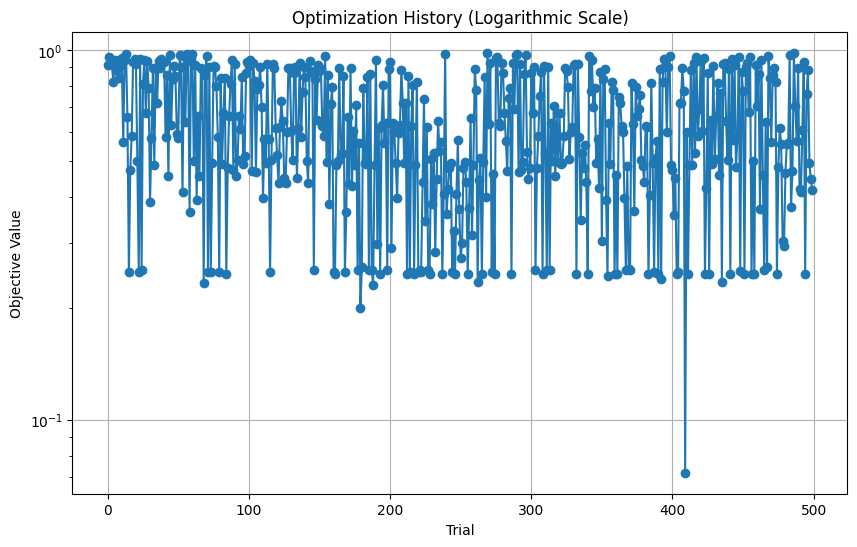

In [ ]:
# Extract trial values
values = [trial.value for trial in study.trials]

# Plot using matplotlib with a logarithmic scale
plt.figure(figsize=(10, 6))
plt.plot(values, marker='o')
plt.yscale('log')
plt.xlabel('Trial')
plt.ylabel('Objective Value')
plt.title('Optimization History (Logarithmic Scale)')
plt.grid(True)
plt.show()


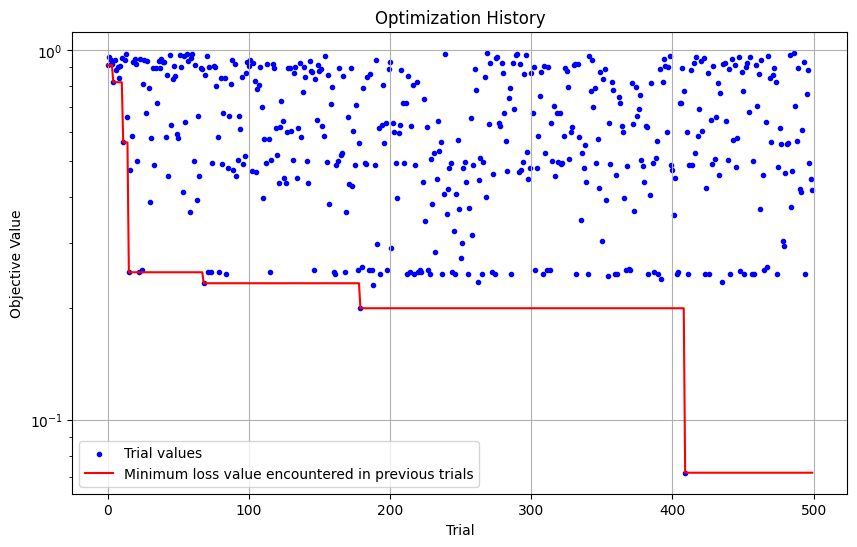

In [ ]:
# Compute the minimum value observed up to each trial
min_values = [min(values[:i+1]) for i in range(len(values))]

# Plot using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(range(len(values)), values, marker='.', c='blue', label='Trial values')
plt.plot(range(len(values)), values, linestyle='', color='blue', alpha=0.5)
plt.plot(range(len(min_values)), min_values, linestyle='-', color='red', label='Minimum loss value encountered in previous trials')
plt.yscale('log')
plt.xlabel('Trial')
plt.ylabel('Objective Value')
plt.title('Optimization History')
plt.legend()
plt.grid(True)
plt.show()